In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm

## simulation

In [12]:
N_p = 40_000
max_t = 4
x_range = (-6e-3,9e-3)
dx = 0.00004*2
tau = 0.1
D = 1e-6
dt = 1e-3 *2
F_ext = lambda t:0
boundary = 'reflective'

bins = np.arange(x_range[0]-dx/2, x_range[1]+dx/2+dx/2,dx)
x_s = np.arange(x_range[0], x_range[1]+dx/2,dx)

t_s = np.arange(0,max_t+dt/2,dt)
N_t = len(t_s)
ntau = int(tau/dt)

def f1(x_tau,t):
    return -300_000*x_tau**3

def f2(x_tau,t):
    return -3*x_tau

def f3(x_tau,t):
    return f1(x_tau,t)-0.25*f2(x_tau,t)

def f4(x_tau,t):
    return (f1(x_tau-0.0016,t)-0.25*f2(x_tau-0.0016,t))


def f5(x_tau,t): # not working
    return - 0.01*np.abs(x_tau)/x_tau

def f6(x_tau,t): # not working
    if x_tau < 0.001:
        return -3*(x_tau)
    else:
        return -3*(x_tau-0.002)
f6 = np.vectorize(f6)

f = f6

In [13]:
#plot_x_s[plot_x_s < -0.001][np.argmin(np.abs(f3(plot_x_s[plot_x_s < -0.001],None)))]

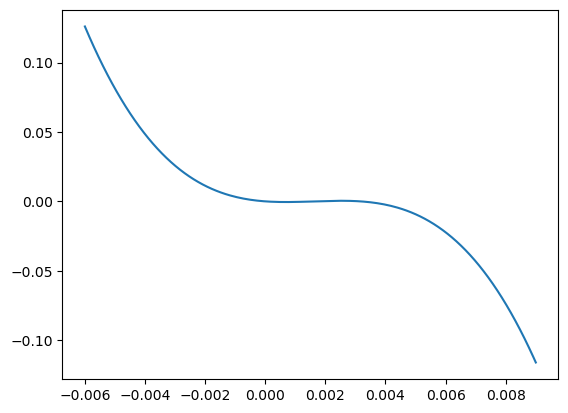

In [14]:
plot_x_s = np.linspace(*x_range,200)
#plt.plot(plot_x_s, f1(plot_x_s,None))
#plt.plot(plot_x_s, f2(plot_x_s,None))
#plt.plot(plot_x_s, f3(plot_x_s,None))
plt.plot(plot_x_s, f4(plot_x_s,None))
#plt.ylim(-0.01,0.01)

In [15]:
pos = np.zeros((N_t,N_p))
vel = np.zeros((N_t,N_p))
vel[ntau:] = np.sqrt(2*D)*np.random.randn(N_t-ntau,N_p)* np.sqrt(1 / dt)
for i in range(ntau, N_t):
    pos[i] = pos[i-1] + vel[i - 1] * dt
    vel[i] += f(pos[i-ntau],i*dt)

hists = np.apply_along_axis(lambda d: np.histogram(d, bins = bins)[0]/N_p*1/dx,1,pos) 
sim_var = hists/hists.sum(1)[:,None]@x_s**2 - (hists/hists.sum(1)[:,None]@x_s)**2

In [16]:
class nummerical_solver():
    def __init__(self,
                     f,
                     max_t,
                     x_range,
                     dx,
                     tau,
                     D,
                     dt,
                     F_ext,
                     boundary):
        
        
        
        F_ext = np.vectorize(F_ext)
        ntau = int(tau/dt)
        
        self.x_s = np.arange(x_range[0], x_range[1]+dx/2,dx)
        self.time = np.arange(0, max_t+dt/2,dt)
        
        N_x = len(self.x_s)
        N_t = len(self.time)

        self.data = np.zeros((N_t, N_x))
        self.F = np.zeros((N_t,N_x))
        self.origindists = np.zeros((N_t,N_x,N_x))
        self.variants = np.zeros(N_t)
           
        if tau == 0:
            self.F[:] = f(self.x_s[None,:], self.time[:,None]) + F_ext(self.time)[:,None]
        else:
            self.F[:,:] = F_ext(self.time)[:,None]
            
       
        R = np.zeros((N_t, N_x, N_x))
        self.data[0,:] = 0
        self.data[0,np.argmin(self.x_s**2)] = 1/dx

        rip = np.zeros((N_t,N_x-1))
        rim = np.zeros((N_t,N_x-1))

        t_start = ntau if ntau > 0 else N_t
        ts = slice(0, t_start)
        
        Fm = (self.F[ts,1:] + self.F[ts,:-1])/2

        rip[ts] = D / dx**2 * np.exp((Fm*dx/D)/2)  # r_i->i+1
        rim[ts] = D / dx**2 * np.exp(-(Fm*dx/D)/2)  # r_i+1->i
        if boundary == 'reflective':
            R[ts,0,0] = -rip[ts,0]
            R[ts,-1,-1] = -rim[ts,-1]
            R[ts,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[ts,1:]+rim[ts,:-1]) # -(r_i->i+1 + r_i->i-1) ????
            R[ts,np.arange(0,N_x-1),np.arange(1,N_x)] = rim[ts]
            R[ts,np.arange(1,N_x),np.arange(0,N_x-1)] = rip[ts]
        elif boundary == 'absorbing':
            R[ts,0,0] = -rip[ts,0]
            R[ts,-1,-1] = -rim[ts,-1]
            R[ts,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[ts,1:]+rim[ts,:-1]) # -(r_i->i+1 + r_i->i-1) ????
            R[ts,np.arange(0,N_x-1),np.arange(1,N_x)] = rim[ts]
            R[ts,np.arange(1,N_x-1),np.arange(0,N_x-2)] = rip[ts,:-1]

        self.prop = np.zeros((N_t,N_x,N_x))
        self.prop[:t_start] = np.stack([expm(o*dt) for o in R[ts]])

        initial_con_length = min(t_start+1, len(self.data))
        for i in range(1,initial_con_length):
            self.data[i] = self.prop[i-1]@self.data[i-1]
            
        mx = (self.data[:initial_con_length]/self.data[:initial_con_length].sum(axis = 1)[:,None])@self.x_s
        mx2 = (self.data[:initial_con_length]/self.data[:initial_con_length].sum(axis = 1)[:,None])@ self.x_s**2
        self.variants[:initial_con_length] = mx2-mx**2

        for i in tqdm(range(t_start, N_t-1)):
            dm = self.data[i-ntau]
            dtprop = np.identity(N_x)
            for j in range(i-ntau,i):
                dtprop = np.matmul(self.prop[j],dtprop)
            absrates = dtprop * dm
            self.origindists[i] = absrates / absrates.sum(axis=1)[:,None]
            self.origindists[i][np.isnan(self.origindists[i])] = 0 #nan only behind boundary

            mx = self.origindists[i] @ self.x_s
            #mx2 = self.origindists[i] @ self.x_s**2
            #self.cond_var[i] = np.mean(mx2-mx**2)
            
            self.F[i] += f(mx,i*dt)
            
            Fm = (self.F[i,1:] + self.F[i,:-1])/2

            rip[i] = D / dx**2 * np.exp( (Fm * dx / D)/2)  # r_i->i+1
            rim[i] = D / dx**2 * np.exp(-(Fm * dx / D)/2)  # r_i+1->i

            if boundary == 'reflective':
                R[i,0,0] = -rip[i,0]
                R[i,-1,-1] = -rim[i,-1]
                R[i,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[i,1:]+rim[i,:-1]) # -(r_i->i+1 + r_i->i-1) ????
                R[i,np.arange(0,N_x-1),np.arange(1,N_x)] = rim[i]
                R[i,np.arange(1,N_x),np.arange(0,N_x-1)] = rip[i]
            elif boundary == 'absorbing':
                R[i,0,0] = -rip[i,0]
                R[i,-1,-1] = -rim[i,-1]
                R[i,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[i,1:]+rim[i,:-1]) # -(r_i->i+1 + r_i->i-1) ????
                R[i,np.arange(0,N_x-1),np.arange(1,N_x)] = rim[i]
                R[i,np.arange(1,N_x-1),np.arange(0,N_x-2)] = rip[i,:-1]

            self.prop[i] = expm(R[i,:,:]*dt)
            self.data[i+1] = self.prop[i]@self.data[i]
            mx = (self.data[i+1]/self.data[i+1].sum())@self.x_s
            mx2 = (self.data[i+1]/self.data[i+1].sum())@ self.x_s**2
            self.variants[i+1] = mx2-mx**2
            
        self.num_paarticles = self.data.sum(1)
        self.rate = -np.diff(self.num_paarticles)/self.num_paarticles[1:]/dt

In [17]:
nr = nummerical_solver(f,max_t, x_range, dx, tau, D, dt, F_ext, boundary)

  0%|          | 0/1950 [00:00<?, ?it/s]

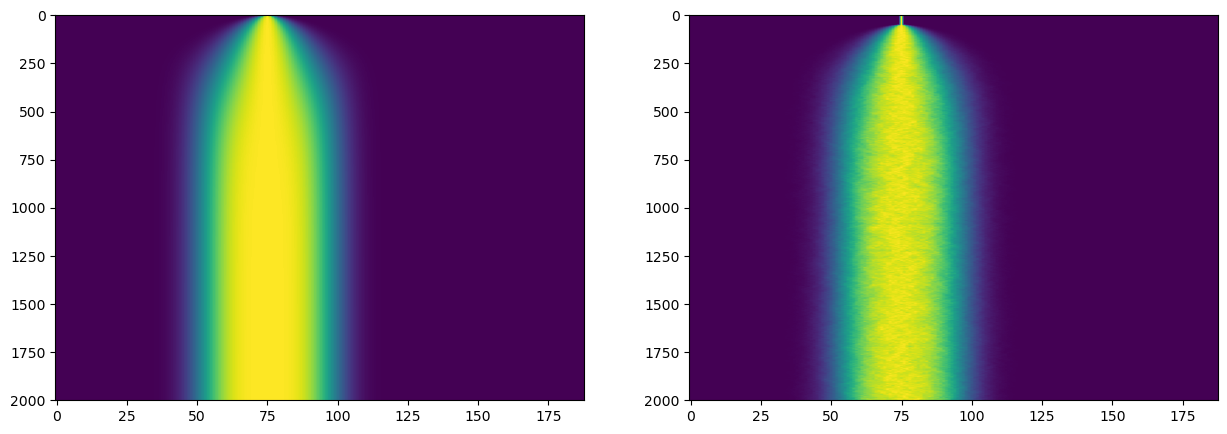

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(nr.data/nr.data.max(1)[:,None], aspect='auto')
plt.subplot(122)
plt.imshow(hists/np.nanmax(hists,1)[:,None], aspect='auto')

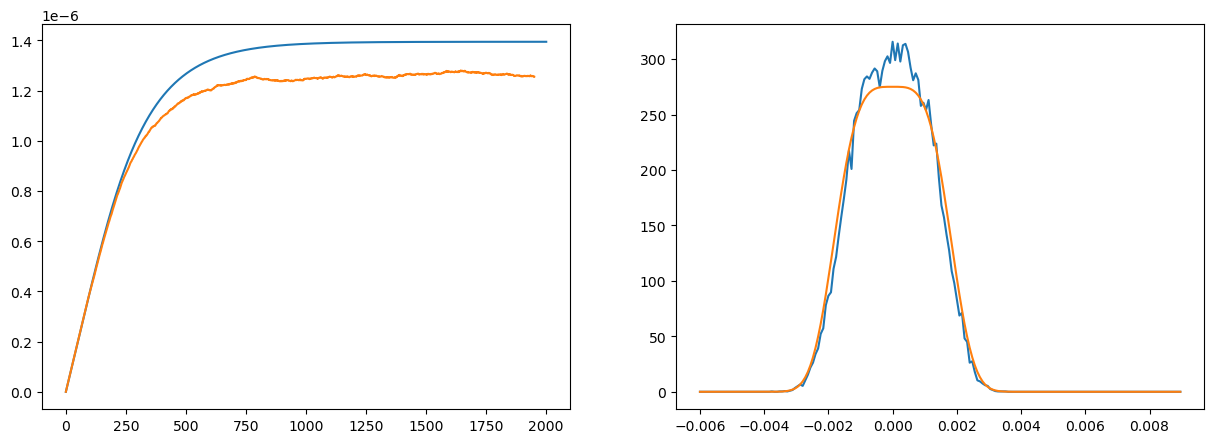

In [19]:
idx = 1950

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(nr.variants)
plt.plot(sim_var[ntau:])
plt.subplot(122)
plt.plot(x_s, hists[idx+ntau])
plt.plot(x_s, nr.data[idx])

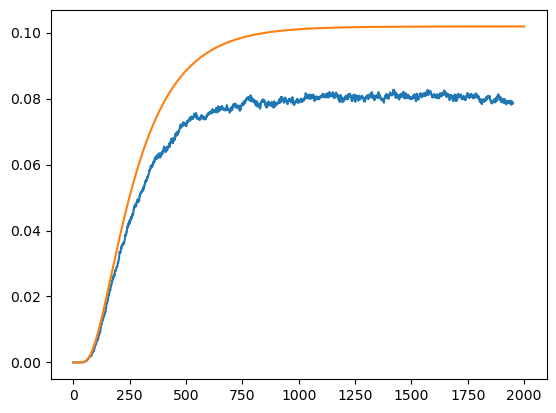

In [20]:
plt.plot((pos[ntau:] > 0.0016).sum(1) / N_p)
plt.plot(nr.data[:,x_s > 0.0016].sum(1)/nr.data.sum(1))

In [221]:
N_p

40000